### Top Starting Stations (NYC Citi Bike, 2022 — sample)

This chart shows the **20 most popular _starting_ stations**.   
- Counts are shown **outside** each bar to keep the plot area uncluttered.


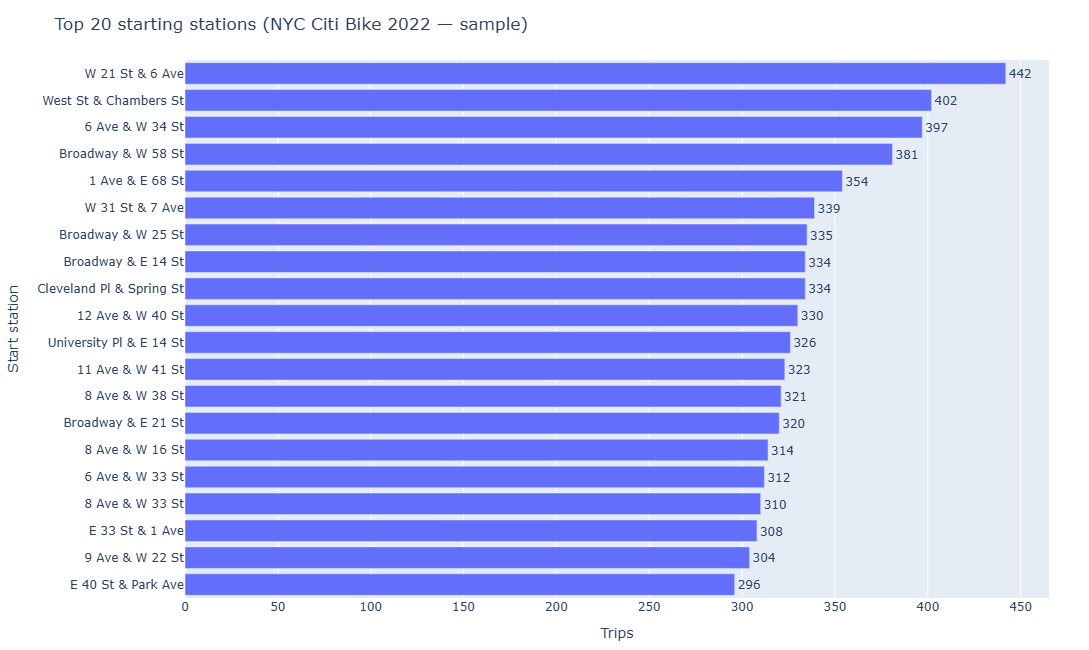

In [2]:
# Paths & data
from pathlib import Path
import pandas as pd
import plotly.express as px

PROJECT = Path.cwd()
if not (PROJECT / "Output").exists():
    PROJECT = PROJECT.parent if (PROJECT.parent / "Output").exists() else PROJECT
OUT = PROJECT / "Output"
SAMPLE = OUT / "citibike_weather_2022_sample_100k.csv"

df = pd.read_csv(SAMPLE)
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
df["start_station_name"] = df["start_station_name"].fillna("Unknown station")

topN = 20
vc = df["start_station_name"].value_counts().head(topN).sort_values(ascending=True)
fig_bar = px.bar(
    x=vc.values, y=vc.index, orientation="h",
    text=vc.values, labels={"x":"Trips", "y":"Start station"},
    title=f"Top {topN} starting stations (NYC Citi Bike 2022 — sample)"
)
fig_bar.update_traces(textposition="outside", cliponaxis=False)
fig_bar.update_layout(
    bargap=0.2,
    height=650,
    margin=dict(t=60, b=40, l=160, r=40),
    xaxis=dict(showgrid=True),
    yaxis=dict(autorange=True),
    showlegend=False
)
fig_bar.show()


### Daily Trips vs. Temperature

Trips are on the **left axis**; temperature (°C) on the **right**.  
Use the **range slider** to focus on specific months or seasons.


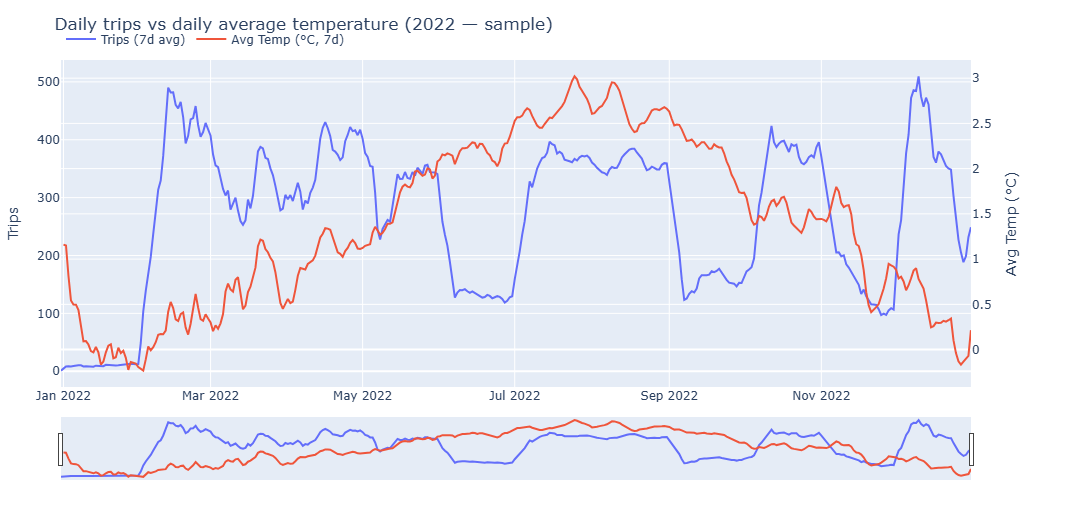

In [3]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# ensure avgTemp exists; if not, merge from weather file
if "avgTemp" not in df.columns:
    weather = pd.read_csv(OUT / "laguardia_weather_2022.csv")
    weather["date"] = pd.to_datetime(weather["date"], errors="coerce").dt.date
    df = df.merge(weather, on="date", how="left")

# daily aggregates
daily_trips = df.groupby("date").size().rename("trip_count").reset_index()
daily_temp  = df.groupby("date")["avgTemp"].mean().rename("avgTemp").reset_index()
d = daily_trips.merge(daily_temp, on="date", how="left").sort_values("date")

# optional smoothing
d["trip_count_7d"] = d["trip_count"].rolling(7, min_periods=1).mean()
d["avgTemp_7d"]    = d["avgTemp"].rolling(7, min_periods=1).mean()

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=d["date"], y=d["trip_count_7d"], mode="lines", name="Trips (7d avg)"), secondary_y=False)
if d["avgTemp_7d"].notna().any():
    fig.add_trace(go.Scatter(x=d["date"], y=d["avgTemp_7d"], mode="lines", name="Avg Temp (°C, 7d)"), secondary_y=True)

fig.update_yaxes(title_text="Trips", secondary_y=False)
fig.update_yaxes(title_text="Avg Temp (°C)", secondary_y=True)
fig.update_layout(
    title="Daily trips vs daily average temperature (2022 — sample)",
    xaxis=dict(type="date", rangeslider=dict(visible=True)),
    hovermode="x unified",
    height=520,
    margin=dict(t=60, b=40, l=60, r=60),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, x=0.0)
)
fig.show()
